# L2 Learner Classifier Project

## Project Objectives

- preprocess text derived from HTML documents
- extract corpus linguistic features
- built a supervised classification system to identify language background 

## Introduction

In this project we will be creating an end-to-end classification system using a corpus of HTML documents scraped from the [Lang-8 language learning website](https://lang-8.com/). In particular, we will be building a classifier to distinguish English text written by Lang-8 users whose native language (L1) is another European language (French and Spanish) from those written by L1 speakers of East Asian languages (Japanese, Korean, and Mandarin Chinese). 

A bit of historical linguistics: Although French and Spanish are closely related languages, being both part of the Romance branch of the Indo-European languages, Japanese, Korean and Mandarin are not considered related by linguists. Therefore, from a purely linguistics perspective our task is not particularly well formed. However, there is a key distinction between European and East Asian languages in terms of their relationship to the "L2" (second language) in this case, English. Although English is in a different branch of the Indo-European language family (Germanic), Spanish and French nonetheless share numerous linguistic similarities with English (particularly with regards to having a shared educated vocabulary), whereas the East Asian Languages, having developed quite separately, have only coincidental similarities with English. One might presume this linguistic distance generally makes English more challenging for East Asian learners, who are in essence "starting from scratch" in a way that Spanish and French speakers are not. We want to consider this as we brainstorm possible features! We also reflect on general cultural differences between East Asia and Europe, and how they might be reflected in linguistic features we can easily extract.

## Part 1: Text extraction from HTML

We first need to write code to extract relevant information from a large collection of HTML documents from the Lang-8 language learning website (lang-8.zip), available under this folder.

Each html file consists of an online diary entry written by a second language learner of English. There are three things that the code will need to pass on to next part of the process, for each file:

- the native language of the writer
- the raw text (string) of the entry, with HTML removed
- the original filename (so that we can use our provided train/dev/test split) 

we'll need to inspect a sample file to identify where this information is contained in the HTML, and then write code to pull it out.

In [1]:
import re
import zipfile
import io
import sys
import nltk as nltk
from bs4 import BeautifulSoup
from bs4.element import Tag, NavigableString
from nltk import word_tokenize, sent_tokenize
from urllib.request import urlopen
import pandas as pd
import zipfile
import glob, os

# nltk.download('averaged_perceptron_tagger')

In [2]:
def unzip(path, folder):
    """
    This function unzips a zip file and saves the resulting directory inside the working directory.

    Parameters
    ----------
    path : str
        Path to find the zipped file.
    folder : str
        Folder in which to save the resulting directory.

    Example
    -------
    >>> unzip("data/lang-8.zip", "data/")
    """
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(folder)


def extract_all(path, des, doc_list_file):
    """
    This function extracts all the relevant data from all of the html files in a directory.

    Parameters
    ----------
    path : str
        Path to find all the relevant html files.
    des : str
        Text file to append the relevant information.

    Example:
    --------
    >>> extract("data/lang-8/", "text/")
    """
    doc_list = []
    with open(doc_list_file, 'r') as f:
        for line in f.readlines():
            file_name = line.strip()
            full_path = os.path.join(path, file_name)
            doc_list.append(full_path)
    with open(des, "w") as text_file:
        for file_name in doc_list:
            name, body, native = extract_one(file_name)
            text_file.write(name + '\r\n' + body + '\r\n' + native + '\r\n' + '\r\n')


def extract_one(file):
    """
    This function extracts all the relevant information from an html file.

    Parameters
    ----------
    file : str
        Html file from which to extract the relevant information.

    Returns
    -------
    str
        Filename with .html suffix
    str
        Body of the blog post.
    str
        Native language of speaker.

    Example:
    --------
    >>> extract_one("data/lang-8/5210.html")
    """
    with open(file, 'r') as fp:
        soup = BeautifulSoup(fp, "html.parser")
        native = soup.find(title="Native language").get_text()
        name = file
        body = soup.find(id="body_show_ori").get_text()
    return name, body, native

In [3]:
# The unzipped text files are already in the repo. Only run this block to regenerate text files.
# unzip("data/lang-8.zip", "data/")
# extract_all("data/lang-8/", "train_text.txt", "data/train.txt")
# extract_all("data/lang-8/", "dev_text.txt", "data/dev.txt")
# extract_all("data/lang-8/", "test_text.txt", "data/test.txt")

## Part 2: Feature Extraction

The next step is to go from a general text representation to a set of features for each text, in the right format to be fed into Scikit-Learn. 

- We will first want to apply general text preprocessing techniques to get a useful Python data structure that isn't just raw text.
- Then we should extract some features from the texts. we have significant leeway which features we extract, but for full points we need to follow the rules below:
    - We are intending to give the final system **only 10 features**. We may choose to test more than that using the dev set, but we will have to drop some before we do the final test.
        - Any feature which has a categorical (string) value is actually a different feature for each categorical value (it becomes "one-hot"). All the features for this project should probably have values that are either numerical or boolean, which result in a single feature.
    - We must have at least one boolean feature based on a lexicon, meaning a feature which is True (or 1) if a word from a set of words we decide on is somewhere in the text, or False (0) otherwise. Some more rules for our lexicon(s):
         - A lexicon must contain at least three words
         - If it contains more than 10 words, we must store it in a separate text file and load it 
         - Although we may use purely statistical means to identify promising words, the lexicon must have an interpretable meaning other than a set of words that make the classifier do better. There needs to be something that ties all these lexical items together in a human interpretable way. E.g. {"car", "truck", "train", "boat"} are all modes of transport.
    - we must have at least one "statistic", one that is **not** just the count of a specific lexical item (or a lexicon of items) in a text.
    - we must have one feature that involves doing sentence segmentation
    - we must have one feature that involves doing part-of-speech tagging
    - we must have one feature that involves doing lemmatization or stemming 
    - A single feature can satisfy more than one of the requirements above. For example, we might have a statistic that relies on sentence segmentation, satisfying both the statistic and sentence segmentation requirement.
    - we can do preprocessing as part of our feature extraction. For example, POS tagging and lemmatization are actually somewhat incompatible, and so we may want to do those independently
    - If we look at the corpus to develop our features (a good idea) we should make sure that we look in the training set, not the dev or test sets.

- As we are building these feature dictionaries (our "X"), we will be also be creating the list of classifications (our "y"). we should map those texts with L1 either Spanish or French to the "European" classification, and Japanese, Korean, and Mandarin to the "Asian" classification. There are also Russian texts in the corpus, but we are not going to use them.
- Before we create the feature dictionaries, we will want to load the list of filenames found in `train.txt`, `dev.txt`, and `test.txt` files and use them to create 3 separate lists of feature dicts (and corresponding lists of classifications, i.e. "European" and "Asian") for each of the train/dev/test splits, using the filename returned from Part 1. Note that the Russian texts we are not using are included in the splits, so we should not create the splits by iterating over train/dev/text.txt, but rather iterate over all the documents in the corpus and put the extracted features for relevant texts in the appropriate list, based on whether they are in the lists of train, dev, or test sets we have already loaded beforehand.
  

In [4]:
# get the pos tagged text
def pos_tagging(text):
    """
    This function returns a list of sentences with the parts of speech tags for each word.

    Parameters
    ----------
    text : str
        A string of text which needs to be tagged.

    Returns
    -------
    [(str, str)]
        array of tuples containing words and their respective parts of speech.
    """
    return [nltk.pos_tag(sent.split(' ')) for sent in text.split('. ')]


# Get the average sentence length
def average_sent_length(text):
    """
    This function calculates the average length of the given text.

    Parameters
    ----------
    text : str
        A string of text to calculate the average length.

    Returns
    -------
    float
        Average length of a sentence.
    """
    total_sents = len(text.split('. ')) # minus one because the ending period will be split to \n
    total_words = sum([len(sent.split(' ')) for sent in text.split('. ')])
    return total_words/max(total_sents,1)

# Get the total text length
def total_text_length(text):
    """
    This function calculates the total length of the given text.

    Parameters
    ----------
    text : str
        A string of text to calculate the total length.

    Returns
    -------
    int
        Total text length.
    """
    return len(text)

# Get the number of sentences in text
def num_sent(text):
    """
    This function calculates the number of sentences of the given text.

    Parameters
    ----------
    text : str
        A string of text to calculate the number of sentences.

    Returns
    -------
    int
        Number of sentences.
    """
    return max(len(text.split('. ')),1)

# Get relative frequency of prepositions for each document
def freq_preposition(text):
    """
    This function calculates the frequency of prepositions for the given text.

    Parameters
    ----------
    text : str
        A string of text to calculate the frequency of prepositions.

    Returns
    -------
    float
        Frequency of Prepositions.
    """
    w = sum([len(sent.split(' ')) for sent in text.split('. ')])
    text = pos_tagging(text)
    p = 0
    for t in text:
        for sent in t:
            if sent[1]=='IN':
                p+=1
    return p/max(w,1)


# Get the type token ratio for a text
def TTR(text):
    """
    This function calculates the type token ratio for the given text.

    Parameters
    ----------
    text : str
        A string of text to calculate the type token ratio.

    Returns
    -------
    float
        Type to token ratio.
    """
    text = pos_tagging(text)
    pos = set()
    word = set()
    for t in text:
        for sent in t:
            word.add(sent[0])
            pos.add(sent[1])
    return len(pos)/len(word)


# Get lexical density
def lexical_density(text):
    """
    This function calculates the lexical density of the provided text.

    Parameters
    ----------
    text : str
        A string of text to calculate the lexical density.

    Returns
    -------
    float
        Lexical Density.
    """
    open_class_prefix = {"N", "V", "J", "R"}
    open_class_total = 0
    num_word = sum([len(sent.split(' ')) for sent in text.split('. ')])
    
    text = pos_tagging(text)
    for t in text:
        for sent in t:
            if sent[1][0] in open_class_prefix:
                open_class_total += 1
    return open_class_total/max(num_word,1)

# Get percentage of noun in document 
def freq_noun(text):
    """
    This function calculates the frequency of nouns for the given text.

    Parameters
    ----------
    text : str
        A string of text to calculate the frequency of nouns.

    Returns
    -------
    float
        Frequency of nouns.
    """
    w = sum([len(sent.split(' ')) for sent in text.split('. ')])
    text = pos_tagging(text)
    p = 0
    for t in text:
        for sent in t:
            if sent[1].startswith('NN'):
                p+=1
    return p/max(w,1)


# Get the relative frequency of modal verbs
def freq_model_verb(text):
    """
    This function calculates the frequence of modal verbs for the given text.

    Parameters
    ----------
    text : str
        A string of text to calculate the frequency of modal verbs.

    Returns
    -------
    float
        Frequency of modal verbs.
    """
    w = sum([len(sent.split(' ')) for sent in text.split('. ')])
    text = pos_tagging(text)
    p = 0
    for t in text:
        for sent in t:
            if sent[1] == 'MD':
                p+=1
    return p/max(w,1)




# Get relative frequency of articles for each document
# def freq_article(text):
#     """
#     This function calculates the frequency of articles for the given text.

#     Parameters
#     ----------
#     text : str
#         A string of text to calculate the frequency of articles.

#     Returns
#     -------
#     float
#         Frequency of articles.
#     """
#     w = sum([len(sent.split(' '))-1 for sent in text.split('.')])
#     text = pos_tagging(text)
#     p = 0
#     for t in text:
#         for sent in t:
#             if sent[1] == 'RP':
#                 p+=1
#     return p/max(w,1)


# Get relative frequency of adjectives and adverbs for each document
def freq_adj_adv(text):
    """
    This function calculates the frequency of adjectives and adverbs for the given text.

    Parameters
    ----------
    text : str
        A string of text to calculate the frequency of adjectives and adverbs.

    Returns
    -------
    float
        Frequency of adjectives and adverbs.
    """
    w = sum([len(sent.split(' ')) for sent in text.split('. ')])
    text = pos_tagging(text)
    p = 0
    for t in text:
        for sent in t:
            if sent[1].startswith('JJ') or sent[1].startswith('RB'):
                p+=1
    return p/max(w,1)


def if_other_eng(text):
    """
    This function returns a boolean of whether the text contains other languages other than English.

    Parameters
    ----------
    text : str
        A string of text to check for languages other than English.

    Returns
    -------
    bool
        Returns True if languages are present other than English.
    """
    for s in text:
        if s.isascii() is False:
            return 1
    return 0

In [5]:
test_str = 'I hate doing homework. This is so boring but useful. Life is too hard.'
short_str = 'I am okay.'
test_str2 = 'I am under the water.'
test_str3 = 'I will pass this course.'
test_str4 = '이 속제는 재미없어요.'

# test for pos_tagging
assert len(pos_tagging(test_str)[0]) == 4
assert pos_tagging(test_str)[1][0][1]=='DT'

# test for average_sent_length
assert average_sent_length(test_str) == (4+6+4)/3

# test for total_text_length
assert total_text_length(short_str) == 10

# test for num_sent
assert num_sent(test_str) == 3

# test for freq_preposition
assert freq_preposition(test_str2) == 1/5

# test for TTR
assert TTR(test_str2)== 1

# test for lexical_density
assert lexical_density(test_str2)== 2/5  #am water

# test for freq_noun
assert freq_noun(test_str) == 2/14 #homework life

# test for freq_modal_verb
assert freq_model_verb(test_str3) ==1/5 #will

# test for freq_adj_adv
assert freq_adj_adv(test_str) == 5/14 #so boring useful too hard

# test if_other_eng
assert if_other_eng(test_str4) == 1

In [6]:
import re

def extract_dict(file_name):
    with open(file_name, 'r') as f:
        country = []
        lines = f.read()

        reg1 = r"data\/lang-8\/\d+.html\n"
        reg2 = r"\n\n(\w+)\n\n"
        reg3 = r"(\n\n\w+\n\n|\n)"
        lines1 = re.split(reg1, lines)

        for i in lines1:
            extract = re.findall(reg2, i)
            if extract !=[]:
                country.append(extract[0])

        paragraph = []
        for para in lines1:
            process = re.sub(reg3, "", para)
            if process != '':
                paragraph.append(process)
    
    # create dataframe
    df = pd.DataFrame(list(zip(country, paragraph)),
               columns =['Country', 'Paragraph'])
    
    # create features
    df['average_sent_length'] = df['Paragraph'].apply(average_sent_length)
    df['total_text_length'] = df['Paragraph'].apply(total_text_length)
    df['num_sent'] = df['Paragraph'].apply(num_sent)
    df['freq_preposition'] = df['Paragraph'].apply(freq_preposition)
    df['TTR'] = df['Paragraph'].apply(TTR)

    df['lexical_density'] = df['Paragraph'].apply(lexical_density)
    df['freq_noun'] = df['Paragraph'].apply(freq_noun)
    df['freq_model_verb'] = df['Paragraph'].apply(freq_model_verb)
    df['freq_adj_adv'] = df['Paragraph'].apply(freq_adj_adv)
    df['if_other_eng'] = df['Paragraph'].apply(if_other_eng)

    # drop Russian
    df = df[df.Country != 'Russian']

    # create target
    df['target'] = df['Country'].apply(lambda x: 1 if x in ['French', 'Spanish'] else 0)

    # drop columns
    df.drop(columns = ['Country', 'Paragraph'],inplace = True)
    
    # create dict
    result_dict = []
    dict_origin = df.to_dict(orient='index')
    for k, i in dict_origin.items():
        result_dict.append(i)

    return result_dict

In [7]:
train_dict = extract_dict("train_text.txt")
test_dict = extract_dict("test_text.txt")
dev_dict = extract_dict("dev_text.txt")

In [8]:
print(f'length of train set: {len(train_dict)}, length of dev set: {len(dev_dict)}, length of test set: {len(test_dict)}.')

length of train set: 743, length of dev set: 244, length of test set: 252.


In [9]:
# Save the means of features for part 4
class_means = pd.DataFrame(train_dict).groupby('target').mean()

## Part 3: Classification

Now we're going to build and test a machine learning model based on our features.

- First, vectorize our lists of feature dictionaries appropriately, turning them into first into sparse matrices, and then numpy arrays (using `toarray`). With so few features, we don't have to worry about keeping things sparse, and having dense arrays will be useful later.
- Build a sklearn DecisionTreeClassifier with max_depth=3 (for regularization), and get a preliminary [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) on the _dev_ set using all features. we may choose to modify the classifier and hyperparameters settings to get better results, see discussion in "Part 5" below.
- Next, we're going to do feature [ablation](https://en.wikipedia.org/wiki/Ablation_(artificial_intelligence%29), which involves removing features one at a time from our model, and seeing what the effect is. Report results with each feature missing (make it clear which feature is missing for each result we present). If the results go down when we remove the feature, it means the feature is probably useful, and if the results go up or stay the same, then it is probably not.
- The last step of the coding part is checking accuracy of our model on the _test_ set, after removing any features that are not useful based on _dev_ set results.

Notes:

- The most efficient way to do feature ablation is simply to remove a column (check out for instance [np.delete](https://numpy.org/doc/stable/reference/generated/numpy.delete.html). Note that delete doesn't work right with sparse matrices, so we'll definitely want to turn our sparse matrices into ndarrays before doing this. For each feature, we will have to remove it from both the training and dev matrices before building and testing the model.
- There are a few natural ways to modularize into functions, and avoid repeated code. For instance, we can have a general function for deleting a feature from any feature matrix, and a function which does the entire ablation process for one provided feature: given feature matrices and one feature, the function would delete the feature from the matrices, train the model on the ablated training matrix, and test the model on the ablated test matrix.

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.feature_extraction import DictVectorizer

In [11]:
# define x and y
def seperate_feature_and_target(data_dict):
    feature_list = []
    target_list = []
    for data in data_dict:
        target_list.append(data.pop('target'))
        feature_list.append(data)
    return feature_list,target_list

In [12]:
X_train, y_train = seperate_feature_and_target(train_dict)
X_dev, y_dev = seperate_feature_and_target(dev_dict)
X_test, y_test = seperate_feature_and_target(test_dict)

In [13]:
assert len(train_dict) == len(X_train) == len(y_train)
assert len(dev_dict) == len(X_dev) == len(y_dev)
assert len(test_dict) == len(X_test) == len(y_test)

In [14]:
vectorizer = DictVectorizer(sparse=False)

# vectorize the data
train_vectorized = vectorizer.fit_transform(X_train)
dev_vectorized = vectorizer.transform(X_dev)
test_vectorized = vectorizer.transform(X_test)

In [15]:
# build DecisionTreeClassifier 

results = dict()

# DecisionTreeClassifier with max_depth = 3
model = DecisionTreeClassifier(max_depth = 3) # Create a decision tree
model.fit(train_vectorized, y_train) # Fit a decision tree

results['dt_max_depth3'] = round(accuracy_score(model.predict(dev_vectorized),y_dev),3)

# try different hyperparameters
model_hy = DecisionTreeClassifier(max_depth = 3, class_weight = 'balanced') # Create a decision tree
model_hy.fit(train_vectorized, y_train)

results['dt_max_depth3_balanced'] = round(accuracy_score(model_hy.predict(dev_vectorized),y_dev),3)
results

{'dt_max_depth3': 0.664, 'dt_max_depth3_balanced': 0.635}

We notice that if we set `class_weight` to 'balanced', the accuracy would decrease a bit, because our data is imbalanced and when we set hyperparameter `class_weight` to 'balanced', it could lead to decrease in prediction accuracy, but it could increase the recall score. But here, we only focus on accuracy, so we choose not to add `class_weight`. 

In [16]:
results_max_depth = dict()
for i in range(2,11):
    model_m = DecisionTreeClassifier(max_depth = i) # Create a decision tree
    model_m.fit(train_vectorized, y_train)
    results_max_depth[f'dt_max_depth{i}'] = round(accuracy_score(model_m.predict(dev_vectorized),y_dev),3)
results_max_depth

{'dt_max_depth2': 0.68,
 'dt_max_depth3': 0.664,
 'dt_max_depth4': 0.664,
 'dt_max_depth5': 0.709,
 'dt_max_depth6': 0.684,
 'dt_max_depth7': 0.623,
 'dt_max_depth8': 0.697,
 'dt_max_depth9': 0.598,
 'dt_max_depth10': 0.631}

Here we observe that when DecisionTreeClassifier with max_depth at 5, the accuracy score is the hightest around 0.70.

In [17]:
# feature ablation

result_ab = dict()
for i in range(train_vectorized.shape[1]):
    train_ablation = np.delete(train_vectorized, i, 1)
    dev_ablation = np.delete(dev_vectorized, i, 1)
    model_ab = DecisionTreeClassifier(max_depth = 5) # Create a decision tree
    model_ab.fit(train_ablation, y_train)
    result_ab[vectorizer.get_feature_names_out()[i]] = accuracy_score(model_ab.predict(dev_ablation),y_dev)

for k, v in result_ab.items():
    print(f'delete {k}: {round(v, 3)}')

delete TTR: 0.697
delete average_sent_length: 0.689
delete freq_adj_adv: 0.709
delete freq_model_verb: 0.717
delete freq_noun: 0.689
delete freq_preposition: 0.721
delete if_other_eng: 0.713
delete lexical_density: 0.664
delete num_sent: 0.73
delete total_text_length: 0.697


We notice that when we delete `average_sent_length` or `lexical_density`, this would cause the most significant decrease on prediction accuracy. So we deduce that these three features are very useful for prediction. Whereas, when we delete `if_other_eng`, `freq_preposition` or `freq_model_verb`, the accuracy scores barely change, which means that these features are not very useful for prediction. When we delete `num_sent`, the accuracy score increases a little bit, which means that this feature has opposite effect on our prediction. We have good reason to delete it in our prediction model. 

In [18]:
model_best = DecisionTreeClassifier(max_depth = 5) # Create a decision tree
train_best = np.delete(train_vectorized, 8, 1)
test_best = np.delete(test_vectorized, 8, 1)

assert train_best.shape[1] <= 10
assert test_best.shape[1] <= 10


model_best.fit(train_best, y_train)
print(f'test result : {round(accuracy_score(model_best.predict(test_best),y_test),3)}.')

test result : 0.651.


## Part 4: Report

Finally, we would like to report results and give a brief summary of our project.

**Mean values by class**

In [19]:
class_means

,average_sent_length,total_text_length,num_sent,freq_preposition,TTR,lexical_density,freq_noun,freq_model_verb,freq_adj_adv,if_other_eng
target,,,,,,,,,,
0,32.038254,530.778656,4.353755,0.082311,0.373347,0.656940,0.296410,0.017061,0.155487,0.221344
1,31.210627,693.763713,5.223629,0.092067,0.315693,0.617509,0.292324,0.014244,0.132767,0.308017


**Features**

We used the following features:

`average_sent_length`: average sentence length. Non native English speakers might have different preference for sentence length depending on their L1 language. Asian languages might generally have shorter clauses and Asian language speaker might be more used to using shorter sentences when speaking English.\
`total_text_length`: total text length. We noticed that on average European language speakers use longer texts.\
`num_sent`: number of sentences. We noticed that on average European language speakers use more sentences per text.\
`freq_preposition`: frequency of prepositions. French and Spanish, like English use mainly prepositions whereas Korean, Japanese use  and Chinese often use postpositions. We suspect that L2 English speakers from these two groups might use prepositions differently when speaking English.\
`TTR`: type token ratio. The rational is that a higher TTR corresponds to a richer lexicon. Two groups of L2 English speakers might have different levels of lexical richness.\
`lexical_density`: lexical density corresponds to complexity of the language. On average, Asian language speakers have higher lexical density.\
`freq_noun`, `freq_model_verb`, `freq_adj_adv`: frequency of nouns, frequency of model verbs, frequency of adjective and adverbs. Different languages use different classes of words differently. We could potentially use the freqeuency of different classes of words to identify L1 speakers of different languages.\
`if_other_eng`: whether the text contains other languages other than English. There are non-English texts in the original texts. We noticed more Asian language texts in the training data, but European language speakers actually have more texts with non-English characters.

**Decision tree of the best model**

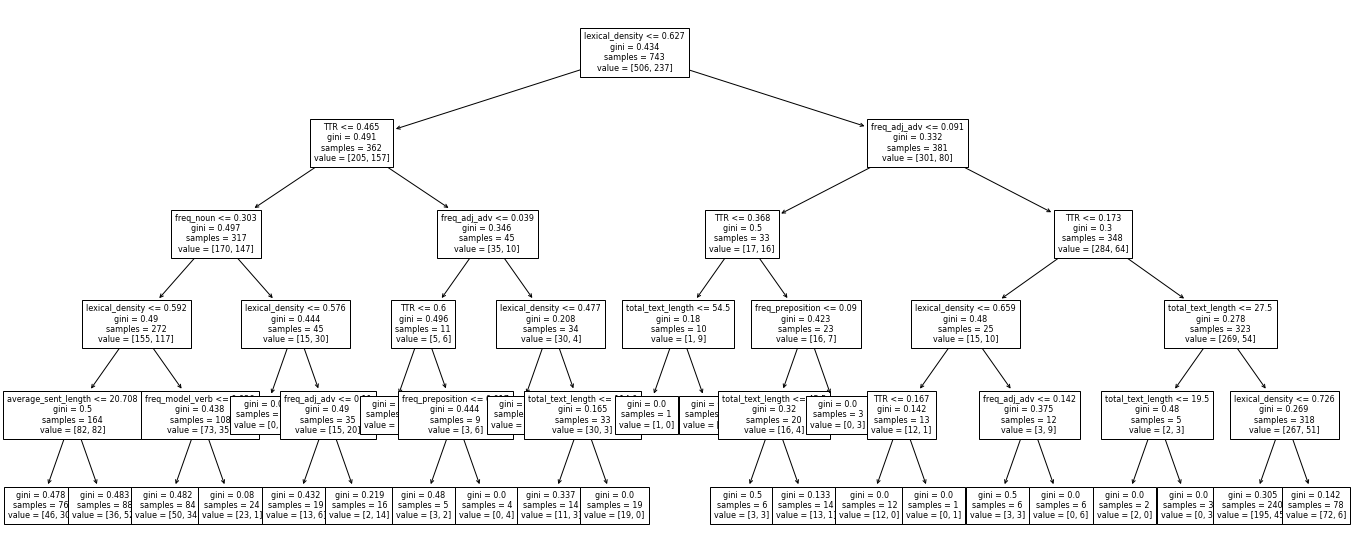

In [20]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 10))
feature_names = vectorizer.get_feature_names_out().tolist()
feature_names.remove('num_sent')
plot_tree(model_best, feature_names=feature_names, fontsize=8);

During feature ablation, we found that `lexical_density` and `average_sent_length` are probably the most useful features and `num_sent` is likely not very useful. We ended up dropping `num_sent` in our best model. From the decision tree plot, we can easily see that `lexical_density` is indeed selected as the criterion to split the root node and a few other nodes on,  but the effect of `average_sent_length` is not as obvious. The decision tree gives `freq_adj_adv` and `TTR` as another two important features.

**Results**

In [21]:
feature_importance = pd.DataFrame(data=model_best.feature_importances_,
                     index=feature_names,
                     columns=['feature importance from decision tree']).sort_values('feature importance from decision tree', ascending=False)
ab_feature_ranking = pd.DataFrame({'accuracy after deleting feature':result_ab})
ab_feature_ranking['ranking according to feature ablation'] = ab_feature_ranking['accuracy after deleting feature'].rank(ascending=True).astype(int)
feature_results = feature_importance.join(ab_feature_ranking, how='left')
feature_results

,feature importance from decision tree,accuracy after deleting feature,ranking according to feature ablation
lexical_density,0.376859,0.663934,1
freq_adj_adv,0.170229,0.709016,6
TTR,0.169394,0.696721,4
total_text_length,0.092491,0.696721,4
freq_preposition,0.054476,0.721311,9
freq_model_verb,0.054286,0.717213,8
freq_noun,0.047647,0.688525,2
average_sent_length,0.034619,0.688525,2
if_other_eng,0.000000,0.713115,7
